# Housing Prices — Preprocessing, Similarity Metrics, and Fair Model Comparison

**Primary Goal:** Study, Practice, and Evaluate Data Preprocessing and Similarity Techniques with Distance Measures.  
**Secondary:** Demonstrate that skipping preprocessing yields poorer model performance, while proper preprocessing (with similarity-based imputation and distance analysis) leads to better outcomes.  
Specified local paths:
- Raw data → `./htrain.csv` (`df_raw`)
- Cleaned output → `./htrain_cleaned.csv`
- Definitive cleaned input (if provided) → `./df_cleaned.csv` (`df_cleaned`)

## Part 1 — EDA & Cleaning
- load dataset(s) from CSV
- identify numeric/categorical columns
- inspect missing values
- cap outliers via IQR/winsorization
- impute numeric features with KNN (similarity-based)
- impute categorical features with most-frequent/mode

In [17]:
import pandas as pd, numpy as np  # import required libraries/modules
import matplotlib.pyplot as plt  # import required libraries/modules
from sklearn.impute import SimpleImputer, KNNImputer  # import specific classes/functions

RAW_PATH = "./htrain.csv"
CLEAN_PATH = "./htrain_cleaned.csv"
DF_CLEANED_PATH = "./df_cleaned.csv"

df_raw = pd.read_csv(RAW_PATH)  # load a dataframe from CSV
print("Loaded raw:", RAW_PATH, "| shape:", df_raw.shape)

missing = df_raw.isna().sum().sort_values(ascending=False)
print("Top missingness:\n", missing.head(15))

num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()  # select numeric columns
cat_cols = df_raw.select_dtypes(exclude=[np.number]).columns.tolist()  # select non-numeric (categorical/text) columns

df_imp = df_raw.copy()
if num_cols:
    df_imp[num_cols] = KNNImputer(n_neighbors=5).fit_transform(df_imp[num_cols])  # similarity-based KNN imputation for numeric features
if cat_cols:
    df_imp[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df_imp[cat_cols])  # impute missing values (e.g., most_frequent)

def winsorize_iqr(df, cols, k=1.5):
    out = df.copy()
    for c in cols:
        q1 = out[c].quantile(0.25); q3 = out[c].quantile(0.75)  # compute distribution quantiles (used for IQR)
        iqr = q3 - q1; lower = q1 - k*iqr; upper = q3 + k*iqr
        out[c] = out[c].clip(lower, upper)  # cap values to a lower/upper bound (winsorization)
    return out

df_clean_base = winsorize_iqr(df_imp, num_cols)
print("Post-clean base shape:", df_clean_base.shape) 
      
print("Rows -> before:", len(df_raw), " | after:", len(df_clean_base)) 
print("")
print("Before:")
missing_summary = df_raw.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({"missing_count": missing_summary, "missing_pct": (missing_summary/len(df_raw))*100}).head(20)) 
print("")
print("After:")
missing_summary = df_clean_base.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({"missing_count": missing_summary, "missing_pct": (missing_summary/len(df_clean_base))*100}).head(20))

Loaded raw: ./htrain.csv | shape: (1460, 81)
Top missingness:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
dtype: int64
Post-clean base shape: (1460, 81)
Rows -> before: 1460  | after: 1460

Before:


,missing_count,missing_pct
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945



After:


,missing_count,missing_pct
Id,0,0.0
CentralAir,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
KitchenAbvGr,0,0.0


## Part 2 — Transformation & Feature Engineering 
- load dataset(s) from CSV
- save dataframe to CSV
- identify numeric/categorical columns
- standardize numeric features
- one-hot encode categorical features
- assemble preprocessing with ColumnTransformer
- chain steps with sklearn Pipeline
- feature engineering (AgeWhenSold, TotalSF, TotalBaths)

In [18]:
import os  # import required libraries/modules
from sklearn.compose import ColumnTransformer  # import specific classes/functions
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # import specific classes/functions
from sklearn.pipeline import Pipeline  # import specific classes/functions
from packaging.version import Version  # import specific classes/functions
import sklearn  # import required libraries/modules

TARGET = "SalePrice"

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Add engineered features (create columns even if sources missing, to keep schema stable)
    out["AgeWhenSold"] = (
        out["YrSold"] - out["YearBuilt"]
        if {"YrSold","YearBuilt"}.issubset(out.columns) else np.nan
    )
    out["TotalSF"] = (
        out["TotalBsmtSF"] + out["1stFlrSF"] + out["2ndFlrSF"]
        if {"TotalBsmtSF","1stFlrSF","2ndFlrSF"}.issubset(out.columns) else np.nan
    )
    out["TotalBaths"] = (
        out["FullBath"] + 0.5*out["HalfBath"] + out["BsmtFullBath"] + 0.5*out["BsmtHalfBath"]
        if {"FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"}.issubset(out.columns) else np.nan
    )
    return out

def version_safe_ohe():
    ohe_kwargs = dict(handle_unknown="ignore")
    # sklearn >= 1.2 uses sparse_output; older uses sparse
    if Version(sklearn.__version__) >= Version("1.2"):
        ohe_kwargs["sparse_output"] = False
    else:
        ohe_kwargs["sparse"] = False
    return OneHotEncoder(**ohe_kwargs)  # one-hot encode categorical features

# 1) Feature engineering
df_clean_fe = engineer_features(df_clean_base)

# 2) Build X (features) and y (optional), removing the target safely
X = df_clean_fe.drop(columns=[TARGET], errors="ignore")
y = df_clean_fe[TARGET].astype(float) if TARGET in df_clean_fe.columns else None

# 3) Derive column lists FROM X (so 'SalePrice' can’t sneak in)
num_cols_X = X.select_dtypes(include=[np.number]).columns.tolist()  # select numeric columns
cat_cols_X = X.select_dtypes(exclude=[np.number]).columns.tolist()  # select non-numeric (categorical/text) columns

# 4) ColumnTransformer built on X’s columns only
preprocess = ColumnTransformer(  # build a unified preprocessing transformer by column type
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols_X),  # scale/standardize numeric features to zero mean / unit variance
        ("cat", Pipeline([("ohe", version_safe_ohe())]), cat_cols_X),  # create an sklearn Pipeline to chain steps
    ],
    remainder="drop"
)

# 5) Fit on X (no KeyError if target is absent)
X_matrix = preprocess.fit_transform(X)
print(f"Preprocess OK → X_matrix shape: {X_matrix.shape} (num={len(num_cols_X)}, cat={len(cat_cols_X)})")

# 6) Persist the cleaned, engineered table (columns are readable; encodings live in the transformer)
CLEAN_PATH = "./htrain_cleaned.csv"
df_clean_fe.to_csv(CLEAN_PATH, index=False)  # write dataframe to CSV
print("Saved cleaned file to:", CLEAN_PATH)

# 7) If a definitive cleaned dataset exists, load it; otherwise keep the one we built
DF_CLEANED_PATH = "./df_cleaned.csv"
if os.path.exists(DF_CLEANED_PATH):
    df_cleaned = pd.read_csv(DF_CLEANED_PATH)  # load a dataframe from CSV
    print("Loaded definitive cleaned dataset from:", DF_CLEANED_PATH, "| shape:", df_cleaned.shape)
else:
    df_cleaned = df_clean_fe.copy()
    print("Using built cleaned dataset (no df_cleaned.csv found).")

Preprocess OK → X_matrix shape: (1460, 291) (num=40, cat=43)
Saved cleaned file to: ./htrain_cleaned.csv
Using built cleaned dataset (no df_cleaned.csv found).


## Part 3 — Similarity & Distance Measures 
- identify numeric/categorical columns
- standardize numeric features
- one-hot encode categorical features
- compute distance matrices (euclidean/manhattan/jaccard)
- compute cosine similarity
- visualize results with matplotlib

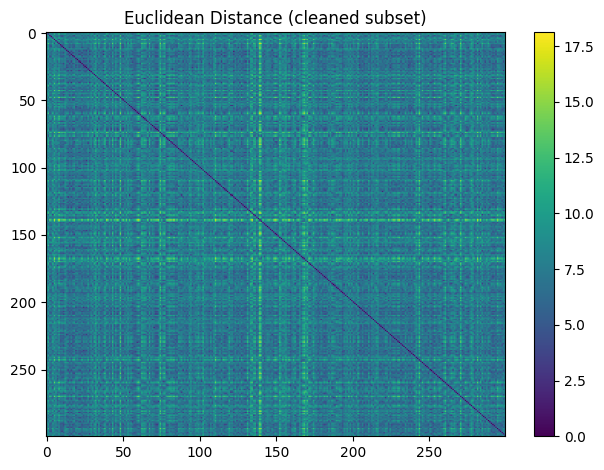

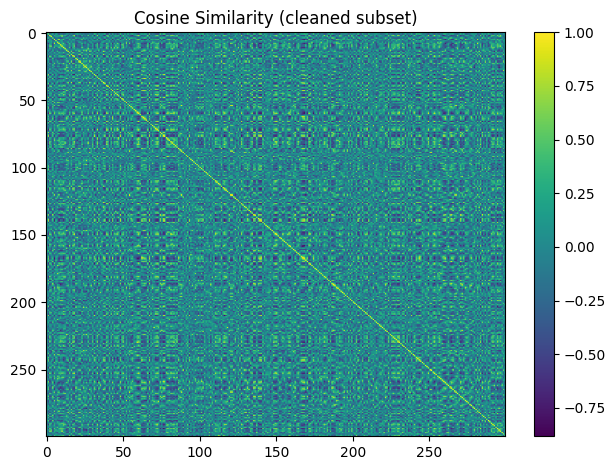

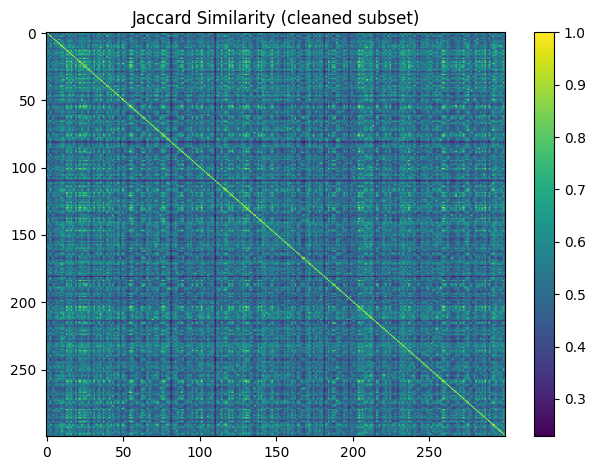

In [19]:
from sklearn.metrics import pairwise_distances  # import specific classes/functions
from sklearn.metrics.pairwise import cosine_similarity  # import specific classes/functions
from sklearn.preprocessing import StandardScaler  # import specific classes/functions
import numpy as np  # import required libraries/modules
import matplotlib.pyplot as plt  # import required libraries/modules

subset = df_cleaned.copy()
if subset.shape[0] > 300:
    subset = subset.sample(300, random_state=42).reset_index(drop=True)

num_avail = subset.select_dtypes(include=[np.number]).columns.tolist()  # select numeric columns
num_avail = [c for c in num_avail if c != "SalePrice"]
if len(num_avail) < 5:
    for k in range(5 - len(num_avail)):
        subset[f"dummy_{k}"] = np.random.randn(len(subset))
    num_avail = subset.select_dtypes(include=[np.number]).columns.tolist()  # select numeric columns

Z = StandardScaler().fit_transform(subset[num_avail])  # scale/standardize numeric features to zero mean / unit variance

D_eu = pairwise_distances(Z, metric="euclidean")  # compute pairwise distances between rows
S_co = cosine_similarity(Z)  # compute cosine similarity between rows

plt.figure(); plt.imshow(D_eu, aspect="auto"); plt.colorbar(); plt.title("Euclidean Distance (cleaned subset)"); plt.tight_layout(); plt.show()  # render a matrix as an image (heatmap-like)
plt.figure(); plt.imshow(S_co, aspect="auto"); plt.colorbar(); plt.title("Cosine Similarity (cleaned subset)"); plt.tight_layout(); plt.show()  # render a matrix as an image (heatmap-like)

cat_avail = subset.select_dtypes(exclude=[np.number]).columns.tolist()  # select non-numeric (categorical/text) columns
if cat_avail:
    from sklearn.preprocessing import OneHotEncoder  # import specific classes/functions
    B = OneHotEncoder(handle_unknown="ignore").fit_transform(subset[cat_avail]).toarray()  # one-hot encode categorical features
    ## D_jac = pairwise_distances(B, metric="jaccard") ## cast the matric to bool to fix the DataConversionWarning
    B_bool = B.astype(bool)
    D_jac = pairwise_distances(B_bool, metric="jaccard")  # compute pairwise distances between rows
    J = 1 - D_jac
    plt.figure(); plt.imshow(J, aspect="auto"); plt.colorbar(); plt.title("Jaccard Similarity (cleaned subset)"); plt.tight_layout(); plt.show()  # render a matrix as an image (heatmap-like)

## Part 4 — Fair Model Comparison: Cleaned vs Raw 
- identify numeric/categorical columns
- impute numeric features with KNN (similarity-based)
- standardize numeric features
- chain steps with sklearn Pipeline
- train Gradient Boosting model
- evaluate with cross-validation
- calculate RMSE / MAE / R² metrics
- visualize results with matplotlib

Common numeric features used: 37
Cleaned + Preprocessing (KNN + Scale + GBR): {'RMSE': 21914.981554256454, 'MAE': 15114.437380196814, 'R2': 0.8886016534072766}
Raw (No Preprocessing) — same numeric cols: {'RMSE': 27830.80320406112, 'MAE': 17189.196587517705, 'R2': 0.8854975241003598}


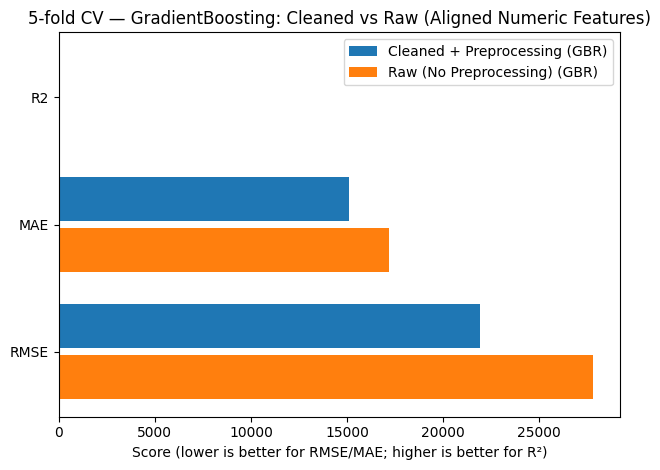

In [20]:
# Part 4 — Gradient Boosting: Cleaned vs Raw (Aligned Features, 5-fold CV)

import numpy as np  # import required libraries/modules
import matplotlib.pyplot as plt  # import required libraries/modules
from sklearn.model_selection import KFold, cross_validate  # import specific classes/functions
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score  # import specific classes/functions
from sklearn.pipeline import Pipeline  # import specific classes/functions
from sklearn.impute import KNNImputer  # import specific classes/functions
from sklearn.preprocessing import StandardScaler  # import specific classes/functions
from sklearn.ensemble import GradientBoostingRegressor  # import specific classes/functions

# --- Config ---
TARGET = "SalePrice"
RANDOM_STATE = 42
N_SPLITS = 5

# --- Metric helpers ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))  # compute MSE (basis for RMSE)

rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer  = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer   = make_scorer(r2_score)

cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)  # 5-fold cross-validation splitter
scoring = {"RMSE": rmse_scorer, "MAE": mae_scorer, "R2": r2_scorer}

# --- Sanity check: target present ---
assert TARGET in df_cleaned.columns, "df_cleaned must contain the target column."  # sanity check / guard to fail early if condition not met
assert TARGET in df_raw.columns,     "df_raw must contain the target column."  # sanity check / guard to fail early if condition not met

# --- Align feature sets (numeric-only) so both branches use identical inputs ---
clean_numeric = df_cleaned.drop(columns=[TARGET]).select_dtypes(include=[np.number]).columns.tolist()  # select numeric columns
raw_numeric   = df_raw.drop(columns=[TARGET]).select_dtypes(include=[np.number]).columns.tolist()  # select numeric columns
common_numeric = [c for c in clean_numeric if c in raw_numeric]
if not common_numeric:
    raise ValueError("No overlapping numeric features between cleaned and raw datasets.")

X_clean = df_cleaned[common_numeric].copy()
y_clean = df_cleaned[TARGET].astype(float)

X_raw_full = df_raw[common_numeric].copy()
y_raw      = df_raw[TARGET].astype(float)

# --- Pipelines / Models ---
# Cleaned: similarity-based imputation + scaling + GBR
clean_gbr = Pipeline([  # create an sklearn Pipeline to chain steps
    ("imputer", KNNImputer(n_neighbors=5)),  # similarity-based KNN imputation for numeric features
    ("scaler", StandardScaler()),  # scale/standardize numeric features to zero mean / unit variance
    ("gbr", GradientBoostingRegressor(random_state=RANDOM_STATE))  # gradient boosting tree regressor
])

# Raw: NO preprocessing — drop rows with any NA, then fit plain GBR
mask = X_raw_full.notna().all(axis=1)  # mask rows that have no missing values across selected columns
X_raw = X_raw_full.loc[mask].copy()
y_raw2 = y_raw.loc[mask].copy()
raw_gbr = GradientBoostingRegressor(random_state=RANDOM_STATE)  # gradient boosting tree regressor

# --- CV Evaluation helper ---
def cv_scores(model, X, y):
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=False)  # evaluate model via cross-validation on selected metrics
    return {
        "RMSE": -scores["test_RMSE"].mean(),
        "MAE":  -scores["test_MAE"].mean(),
        "R2":    scores["test_R2"].mean()
    }

# --- Evaluate ---
clean_metrics = cv_scores(clean_gbr, X_clean, y_clean)
raw_metrics   = cv_scores(raw_gbr,   X_raw,   y_raw2)

print("Common numeric features used:", len(common_numeric))
print("Cleaned + Preprocessing (KNN + Scale + GBR):", clean_metrics)
print("Raw (No Preprocessing) — same numeric cols:",  raw_metrics)

# --- Visualization ---
labels = ["RMSE", "MAE", "R2"]
clean_vals = [clean_metrics[m] for m in labels]
raw_vals   = [raw_metrics[m]   for m in labels]

plt.figure()
y_pos = np.arange(len(labels))
bar_h = 0.35
plt.barh(y_pos + 0.2, clean_vals, height=bar_h, label="Cleaned + Preprocessing (GBR)")  # horizontal bar chart for metric comparison
plt.barh(y_pos - 0.2, raw_vals,   height=bar_h, label="Raw (No Preprocessing) (GBR)")  # horizontal bar chart for metric comparison
plt.yticks(y_pos, labels)
plt.xlabel("Score (lower is better for RMSE/MAE; higher is better for R²)")  # label x-axis
plt.title("5-fold CV — GradientBoosting: Cleaned vs Raw (Aligned Numeric Features)")  # set plot title
plt.legend()  # show legend
plt.tight_layout()  # adjust layout to prevent label overlap
plt.show()